In [1]:
%pylab inline

import numpy as np
from pprint import pprint
from numpy import linalg as LA
import time

Populating the interactive namespace from numpy and matplotlib


In [1]:
#This function's code was borrowed from my teammate Nicholas Vachon
def softmax(x):
   # x est matrice mxn
   maxparcol = np.max(x, axis = 0)                  #vecteur 1xn
   num = np.exp(x - maxparcol)                      #matrice mxn
   deno = np.sum(np.exp(x - maxparcol), axis = 0)   #vecteur 1xn
   return num / deno                                #matrice mxn

In [2]:
class mlp_mini_batch_matrix:
    
    def __init__(self, eta, d, dh, m, epsilon, minibatch_size, num_iterations, 
                 l11, l12, l21, l22, hardcode_weights=False, shuffle_btw_epochs=False, target_valid_err_rate=4.0):
        self.l11 = l11
        self.l12 = l12
        self.l21 = l21
        self.l22 = l22
        self.target_valid_err_rate = target_valid_err_rate
        self.num_iterations = num_iterations
        self.epsilon = epsilon
        self.K = minibatch_size
        self.shuffle=shuffle_btw_epochs
        self.eta = eta
        self.d = d
        self.dh = dh
        self.m = m
        self.w1 = np.random.uniform(-1.0/np.sqrt(self.d), 1.0/np.sqrt(self.d), (self.dh, self.d))
        self.w2 = np.random.uniform(-1.0/np.sqrt(self.dh), 1.0/np.sqrt(self.dh), (self.m, self.dh))        
        self.b1 = np.zeros((dh, 1))
        self.b2 = np.zeros((m, 1))
        
        #Only used to compare gradients
        if (hardcode_weights == True):        
            self.w1[0][0] = -0.5
            self.w1[0][1] = 0.5
            self.w1[1][0] = -0.3
            self.w1[1][1] = 0.3

            self.w2[0][0] = -0.4
            self.w2[0][1] = 0.4
            self.w2[1][0] = -0.6
            self.w2[1][1] = 0.2
        
    def train(self, traindata, validdata=None, testdata=None, log_file=None):
        
        iteration = 0   
        valid_err = 100.0
        
        while (iteration < self.num_iterations) and (valid_err*100 > self.target_valid_err_rate):
            
            self.loss = 0
            start_batch_i = 0
            train_err_batch = 0
            end_batch_i = np.minimum(self.K, traindata.shape[0])
        
            while start_batch_i < traindata.shape[0]: 
               
                samples = traindata[start_batch_i:end_batch_i, :-1]
                labels = traindata[start_batch_i:end_batch_i, -1]                                         

                self.fprop(samples)
                self.bprop(samples, labels)                                                   
                
                self.grad_w2 = self.grad_w2/samples.shape[0]
                self.grad_b2 = self.grad_b2/samples.shape[0]
                self.grad_w1 = self.grad_w1/samples.shape[0]
                self.grad_b1 = self.grad_b1/samples.shape[0]
                
                #Add the regularization factors
                self.grad_w2 = np.add(self.grad_w2, 2*self.l22*self.w2)
                self.grad_w2 = np.add(self.grad_w2, self.l21*np.sign(self.w2))                
                self.grad_w1 = np.add(self.grad_w1, 2*self.l12*self.w1)
                self.grad_w1 = np.add(self.grad_w1, self.l11*np.sign(self.w1))                

                self.apply_gradient_descent()            

                #After applying the gradient descent, run fprop again to compute the cost and the predictions
                #for this batch
                temp_os = self.fprop(samples)
                self.loss += self.cost(labels)   #cost() uses the updated self.os (updated via call to fprop)
                
                predictions_for_batch = np.argmax(temp_os, axis=0)                
                train_err_batch += (1.0 - np.mean(labels==predictions_for_batch))
                
                #Prepare the parameters for the next batch
                start_batch_i = end_batch_i
                end_batch_i = np.minimum(end_batch_i + self.K, traindata.shape[0])

            ######### Epoch finished ###########                                                                                      
            if (validdata is not None and testdata is not None):
                validdata_predictions = self.compute_predictions(validdata[:, :-1])   
                valid_labels = validdata[:,-1]
                valid_err = 1.0 - np.mean(valid_labels==validdata_predictions)

                testdata_predictions = self.compute_predictions(testdata[:, :-1])   
                test_labels = testdata[:,-1]
                test_err = 1.0 - np.mean(test_labels==testdata_predictions)                
                   
                #Tr/V/Te error / cost after iter {}: {}/{}/{} {}/{}/{}
                to_print= "{0:3d} {1:.2f} {2:.2f} {3:.2f} {4:.4f} {5:.4f} {6:.4f}".format(iteration, 
                        100*train_err_batch/(traindata.shape[0]/self.K), valid_err*100, test_err*100,                                                                                                        
                        self.loss/traindata.shape[0], self.avg_cost(validdata), self.avg_cost(testdata))
                print to_print
                
                if (log_file is not None):
                    log_file.write(to_print + '\n')
            
            iteration+=1   
            
            if (self.shuffle == True):
                inds = range(traindata.shape[0])
                np.random.shuffle(inds)
                traindata = traindata[inds,:] 
            

    def fprop(self, x):              
        self.ha = self.w1.dot(x.T) + self.b1
        #self.ha = np.add(self.w1.dot(x.T), self.b1*np.ones((self.dh, x.shape[0])))
        self.hs = np.where(self.ha > 0, self.ha, 0)
        #self.oa = np.add(self.w2.dot(self.hs), self.b2*np.ones((self.m, x.shape[0])))
        self.oa = self.w2.dot(self.hs) + self.b2
        self.os = softmax(self.oa)
        
        return self.os
        
    #x is a matrix of shape (K x d)
    #y is a column vector of (K x 1)
    def bprop(self, x, y):
        self.grad_oa = self.os - np.eye(self.m)[y.astype(int)].T
        #Sum over gradient for each sample
        self.grad_b2 = np.array([np.sum(self.grad_oa, axis=1)]).T
        
        self.grad_w2 = self.grad_oa.dot(self.hs.T)
        
        self.grad_hs = self.w2.T.dot(self.grad_oa)
        self.grad_ha = np.where(self.ha > 0, self.grad_hs, 0)
        self.grad_w1 = self.grad_ha.dot(x)
        
        #Sum over gradient for each sample
        self.grad_b1 = np.array([np.sum(self.grad_ha, axis=1)]).T
            
    def apply_gradient_descent(self):    
        self.w1-= self.eta*self.grad_w1
        self.w2-= self.eta*self.grad_w2
        self.b1-= self.eta*self.grad_b1
        self.b2-= self.eta*self.grad_b2
                
    def cost(self, y):
        #Cast y, which is a list of target outputs, as an integer array
        return np.sum(-np.log(self.os.T[np.arange(self.os.T.shape[0]), y.astype(int)]))     
    
    #Compute the average cost on the entire given dataset
    def avg_cost(self, dataset):
        dataset_x = dataset[:, :-1]
        dataset_y = dataset[:,-1]        
        fprop_data = self.fprop(dataset_x)
        
        return np.sum(-np.log(fprop_data.T[np.arange(fprop_data.T.shape[0]), dataset_y.astype(int)]))/dataset.shape[0]
    
    def print_vars(self):
        pprint(vars(self))
        
    #Parameter test_data does not contain labels
    #Return list of predictions
    def compute_predictions(self, test_data):
        #argmax over axis=0 because fprop will return matrix of shape (# of classes, # of data points)
        return np.argmax(self.fprop(test_data), axis=0)


In [3]:
import gzip,pickle
f=gzip.open('mnist.pkl.gz')
data=pickle.load(f)
# data[0][0]: matrice de train data
# data[0][1]: vecteur des train labels

# data[1][0]: matrice de valid data
# data[1][1]: vecteur des valid labels

# data[2][0]: matrice de test data
# data[2][0]: vecteur des test labels

In [6]:
traindata_mnist = np.concatenate((data[0][0], np.array([data[0][1]]).T), axis=1)
validdata_mnist = np.concatenate((data[1][0], np.array([data[1][1]]).T), axis=1)
testdata_mnist = np.concatenate((data[2][0], np.array([data[2][1]]).T), axis=1)

In [7]:
#f = open('logfile.500.300epochs.txt', 'w')
#By default, stop once the validation error rate is less than 4%
mlp = mlp_mini_batch_matrix(0.09, 784, 500, 10, epsilon=0.0001, minibatch_size=100, 
                              num_iterations=10,l11=0.00005, l12=0.00015, l21=0.00005, l22=0.00015)
mlp.train(traindata_mnist, validdata_mnist, testdata_mnist)#, log_file=f)

#f.close()

  0 12.01 8.64 9.39 0.5279 0.3119 0.3259
  1 6.87 6.91 7.54 0.2587 0.2524 0.2629
  2 5.59 5.96 6.38 0.2125 0.2162 0.2243
  3 4.63 5.08 5.63 0.1819 0.1918 0.1979
  4 4.07 4.44 5.12 0.1599 0.1740 0.1784
  5 3.53 4.07 4.75 0.1432 0.1605 0.1639
  6 3.14 3.87 4.35 0.1302 0.1498 0.1524


In [8]:
train_predictions = mlp.compute_predictions(traindata_mnist[:, :-1])
train_labels = traindata_mnist[:,-1]
train_err = 1.0 - np.mean(train_labels==train_predictions)
print "training error:",train_err*100

valid_predictions = mlp.compute_predictions(validdata_mnist[:, :-1])
valid_labels = validdata_mnist[:,-1]
valid_err = 1.0 - np.mean(valid_labels==valid_predictions)
print "validation error:",valid_err*100

test_predictions = mlp.compute_predictions(testdata_mnist[:, :-1])
test_labels = testdata_mnist[:,-1]
test_err = 1.0 - np.mean(test_labels==test_predictions)
print "test error:",test_err*100

training error: 4.142
validation error: 3.87
test error: 4.35


The following hyperparameters give a test error rate of 1.93:
<ul>
    <li>Learning rate = 0.09</li>
    <li>Number of hidden neurons = 500</li>
    <li>Epochs = 140</li>
    <li>Lambda 11 = Lambda 21 = 0.00005</li>
    <li>Lambda 12 = Lambda 22 = 0.00015</li>
    <li>Minibatch size = 100</li>
</ul>    
Note that we actually ran 300 epochs but saw that it made sense to stop at 140 as it was then that the validation error rate went under 1.90. The file logfile.500.300epochs.txt includes the number of iteration, train, valid, test error rates and average loss for the train, valid and test data sets.

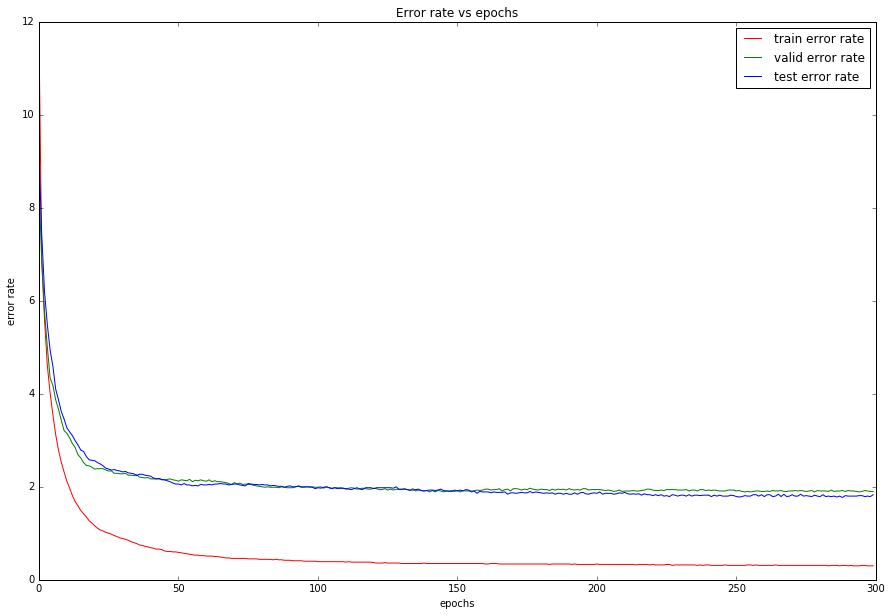

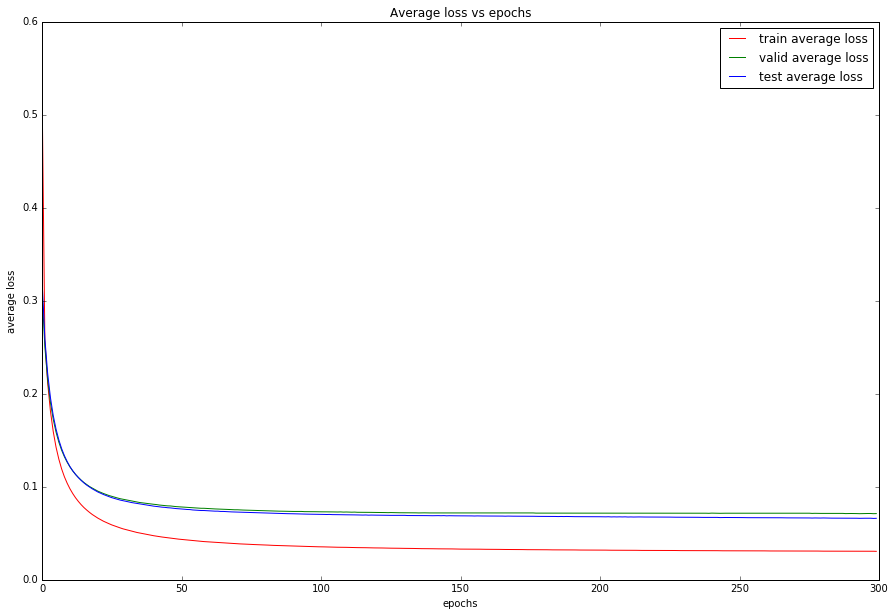

In [24]:
results= np.loadtxt(open('logfile.500.300epochs.txt','r'))

fig1 = plt.figure(1, figsize(15,10))
iterations = results[:, 0].astype(int)
train_err_rate = results[:, 1]
valid_err_rate = results[:, 2]
test_err_rate = results[:, 3]
plt.plot(iterations, train_err_rate, c='r', label='train error rate')
plt.plot(iterations, valid_err_rate, c='g', label='valid error rate')
plt.plot(iterations, test_err_rate, c='b', label='test error rate')
plt.legend(loc='upper right')
plt.ylabel('error rate')
plt.xlabel('epochs')
plt.title('Error rate vs epochs')
plt.show()

fig2 = plt.figure()
iterations = results[:, 0].astype(int)
train_err_rate = results[:, 4]
valid_err_rate = results[:, 5]
test_err_rate = results[:, 6]
plt.plot(iterations, train_err_rate, c='r', label='train average loss')
plt.plot(iterations, valid_err_rate, c='g', label='valid average loss')
plt.plot(iterations, test_err_rate, c='b', label='test average loss')
plt.legend(loc='upper right')
plt.ylabel('average loss')
plt.xlabel('epochs')
plt.title('Average loss vs epochs')
plt.show()

fig1.savefig("img1.pdf", format='pdf')
fig2.savefig("img2.pdf", format='pdf')